In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from prettytable import PrettyTable
import prettytable as pt
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer,StandardScaler, label_binarize,LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import  SMOTE
from sklearn import metrics as m
from sklearn.metrics import recall_score,precision_score,f1_score,accuracy_score,roc_curve,auc,confusion_matrix,roc_auc_score

In [2]:
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit

In [3]:
data=pd.read_csv("bank-full.csv",sep=";",header='infer')

## 觀察類別變數與target之間的關係

In [4]:
import prettytable as pt
from scipy.stats import chisquare
categorical_variable=['marital','job','contact','education','month','poutcome',
                      'housing','loan','default']
table1 = pt.PrettyTable()
table1.field_names=['categorical variable','statistics','p value']
table1.align = 'l'

y_no=data['y']=="no"
data_y_no=data[y_no]
total_y=data.y.value_counts()
a=total_y[0]+total_y[1]

for i in categorical_variable:
    total=data_y_no[i].value_counts()
    Observed = total
    Expected = (data[i].value_counts()*total_y[0]/(a.sum())).round(2)
    stat, pval = chisquare(Observed, Expected)
    table1.add_row( [i, stat,pval])
    
print(table1)

+----------------------+--------------------+------------------------+
| categorical variable | statistics         | p value                |
+----------------------+--------------------+------------------------+
| marital              | 22.98656383110704  | 1.0198377534681978e-05 |
| job                  | 94.85672365738375  | 1.852354065667773e-15  |
| contact              | 121.16235455784002 | 4.896987557713532e-27  |
| education            | 27.950569381723607 | 3.7198473180991226e-06 |
| month                | 358.1983489619531  | 4.459325828485052e-70  |
| poutcome             | 513.7431298227674  | 5.014790276578564e-111 |
| housing              | 102.443235753097   | 4.439068499303657e-24  |
| loan                 | 24.589900622285082 | 7.092246308357823e-07  |
| default              | 2.6579741249367763 | 0.10303188591866443    |
+----------------------+--------------------+------------------------+


* 刪去default變數

## 以下用假設檢定驗證卡方降為是否能提升模型預測表現

In [5]:
def data_continous(data):
    
    # 正歸化
    col_names=['age','balance','day','campaign','pdays','previous','duration']
    features=data[col_names]
    normalizer=Normalizer(norm="max")
    features=normalizer.fit_transform(features.values)
    data[col_names]=features
    
    for i in categorical_variable:
        data=data.drop([i],axis=1)
    
    
    
    return data

categorical_variable=['marital','job','contact','education','month','poutcome',
                      'housing','loan','default']
data_continous=data_continous(data).drop(['y'],axis=1)
data_continous

,age,balance,day,duration,campaign,pdays,previous
0,0.027065,1.000000,0.002333,0.121792,0.000467,-0.000467,0.000000
1,0.291391,0.192053,0.033113,1.000000,0.006623,-0.006623,0.000000
2,0.434211,0.026316,0.065789,1.000000,0.013158,-0.013158,0.000000
3,0.031208,1.000000,0.003320,0.061089,0.000664,-0.000664,0.000000
4,0.166667,0.005051,0.025253,1.000000,0.005051,-0.005051,0.000000
...,...,...,...,...,...,...,...
45206,0.052201,0.844422,0.017400,1.000000,0.003071,-0.001024,0.000000
45207,0.041064,1.000000,0.009832,0.263736,0.001157,-0.000578,0.000000
45208,0.012598,1.000000,0.002975,0.197200,0.000875,0.032196,0.000525
45209,0.085329,1.000000,0.025449,0.760479,0.005988,-0.001497,0.000000


In [6]:
from sklearn.decomposition import PCA
pca=PCA(n_components='mle',whiten=True)
x_pca=pca.fit_transform(data_continous)

In [7]:
def data_categorical(data):

    # 刪除 'default'
    for i in numerical_variable:
        data=data.drop([i],axis=1)
    data=data.drop(['y'],axis=1)
    data=data.drop(['default'],axis=1)
    #類別資料編碼
    data=pd.get_dummies(data)
    
    return data

In [8]:
numerical_variable=['age','balance','day','duration','campaign','pdays','previous']
data_categorical=data_categorical(data)
data_categorical

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
45207,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
45208,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
45209,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [9]:
x_pca=pd.DataFrame(x_pca)
X= pd.concat([x_pca,data_categorical], axis=1)
X

,0,1,2,3,4,5,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,-0.379801,0.902195,-0.324718,0.168682,-0.142454,0.029142,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.291675,-1.224633,-0.348611,-0.148100,-1.714774,0.364327,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0.418551,-1.239957,-0.426713,-0.982725,-2.414745,0.270723,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,-0.384672,1.056899,-0.333221,0.072590,-0.181750,0.001331,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0.422239,-1.106924,-0.303451,0.610012,-0.729862,0.338900,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,-0.192268,-1.328318,-0.248181,1.048774,0.188272,0.312292,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
45207,-0.367249,0.528177,-0.316298,0.236165,-0.089545,0.030937,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
45208,-0.374025,0.714528,-0.169201,0.317136,0.034181,0.059349,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
45209,-0.323709,-0.776821,-0.285940,0.524358,-0.029730,0.232490,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [10]:
y=data.y
y.replace(('yes','no'),(1,0),inplace=True)
data_X = X

In [11]:
classifiers = {'Random Forest Classifier': RandomForestClassifier(n_estimators=35),}
sm = SMOTE(random_state=0)
import warnings
warnings.filterwarnings('ignore')
rs = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=0)
X_SMOTE, y_SMOTE = sm.fit_resample(data_X,y)

In [12]:
ROC_1=[]
for i in range(100):
    rs.get_n_splits(X_SMOTE, y_SMOTE)
    for Name,classify in classifiers.items():
        for train_index, test_index in rs.split(X_SMOTE, y_SMOTE):
            X_train,X_test = X_SMOTE.iloc[train_index], X_SMOTE.iloc[test_index]
            y_train,y_test = y_SMOTE.iloc[train_index], y_SMOTE.iloc[test_index]
            cls = classify
            cls =cls.fit(X_train,y_train)
            y_out = cls.predict(X_test)
            fpr,tpr,thresholds=roc_curve(y_test,y_out)
            ROC_1.append(auc(fpr,tpr))

In [20]:
# 降維後
np.mean(ROC_1)

0.9285990863223

In [14]:
def data_categorical_1(data):

    # 刪除 'default'
    for i in numerical_variable:
        data=data.drop([i],axis=1)
    data=data.drop(['y'],axis=1)
    #類別資料編碼
    data=pd.get_dummies(data)
    
    return data
data_categorical_=data_categorical_1(data)
X= pd.concat([x_pca,data_categorical_], axis=1)
data_X=X

In [15]:
classifiers = {'Random Forest Classifier': RandomForestClassifier(n_estimators=35),}
sm = SMOTE(random_state=0)
import warnings
warnings.filterwarnings('ignore')
rs = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=0)
X_SMOTE, y_SMOTE = sm.fit_resample(data_X,y)

In [16]:
ROC_2=[]
for i in range(100):
    rs.get_n_splits(X_SMOTE, y_SMOTE)
    for Name,classify in classifiers.items():
        for train_index, test_index in rs.split(X_SMOTE, y_SMOTE):
            X_train,X_test = X_SMOTE.iloc[train_index], X_SMOTE.iloc[test_index]
            y_train,y_test = y_SMOTE.iloc[train_index], y_SMOTE.iloc[test_index]
            cls = classify
            cls =cls.fit(X_train,y_train)
            y_out = cls.predict(X_test)
            fpr,tpr,thresholds=roc_curve(y_test,y_out)
            ROC_2.append(auc(fpr,tpr))

In [21]:
# 降維前
np.mean(ROC_2)

0.9278776656318273

In [18]:
import scipy.stats as stats
#import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
#%matplotlib inline
stats.ttest_ind(ROC_1,ROC_2)

Ttest_indResult(statistic=5.0070569354242185, pvalue=1.2190644470623253e-06)

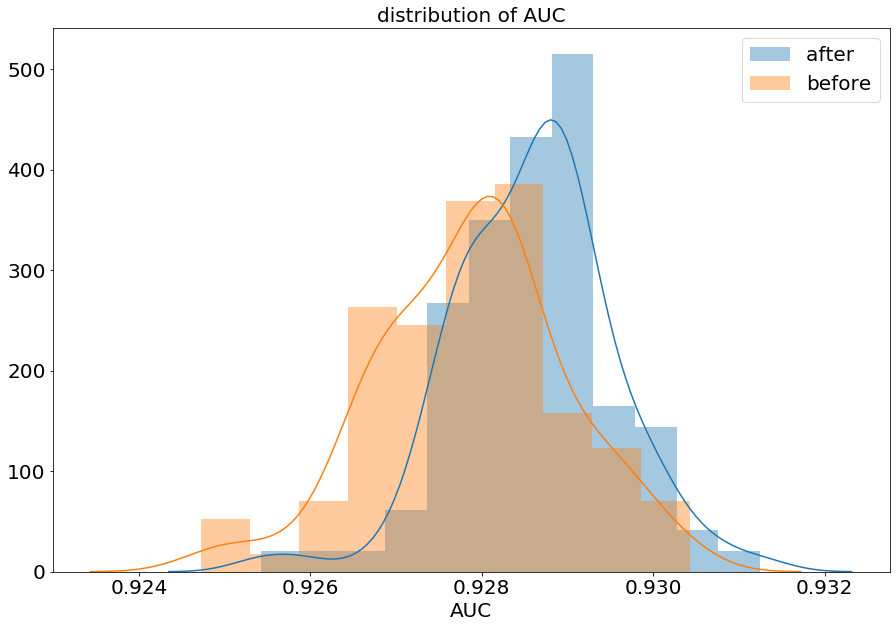

In [19]:
plt.figure(figsize=(15,10))
sns.distplot(ROC_1,kde=True)
sns.distplot(ROC_2,kde=True)
plt.title('distribution of AUC',fontsize=20)
plt.xlabel('AUC',fontsize=20)
plt.legend(['after ','before'],fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

* 卡方降為有助提高模型預測